In [4]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data,confusion_table
from ISLP.models import ModelSpec as MS

In [6]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import(accuracy_score,
                            log_loss)
from sklearn.ensemble import \
          (RandomForestRegressor as RF,
           GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [13]:
Carseats=load_data('Carseats')
High=np.where(Carseats.Sales >8,
              "Yes",
              "No")

In [22]:
model=MS(Carseats.columns.drop('Sales'),intercept=False)
D=model.fit_transform(Carseats)
feature_names=list(D.columns)
X=np.asarray(D)

In [24]:
clf=DTC(criterion='entropy',
        max_depth=3,
        random_state=0)
clf.fit(X,High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [26]:
accuracy_score(High,clf.predict(X))

0.79

In [28]:
resid_dev=np.sum(log_loss(High,clf.predict_proba(X)))
resid_dev

0.47106470626493574

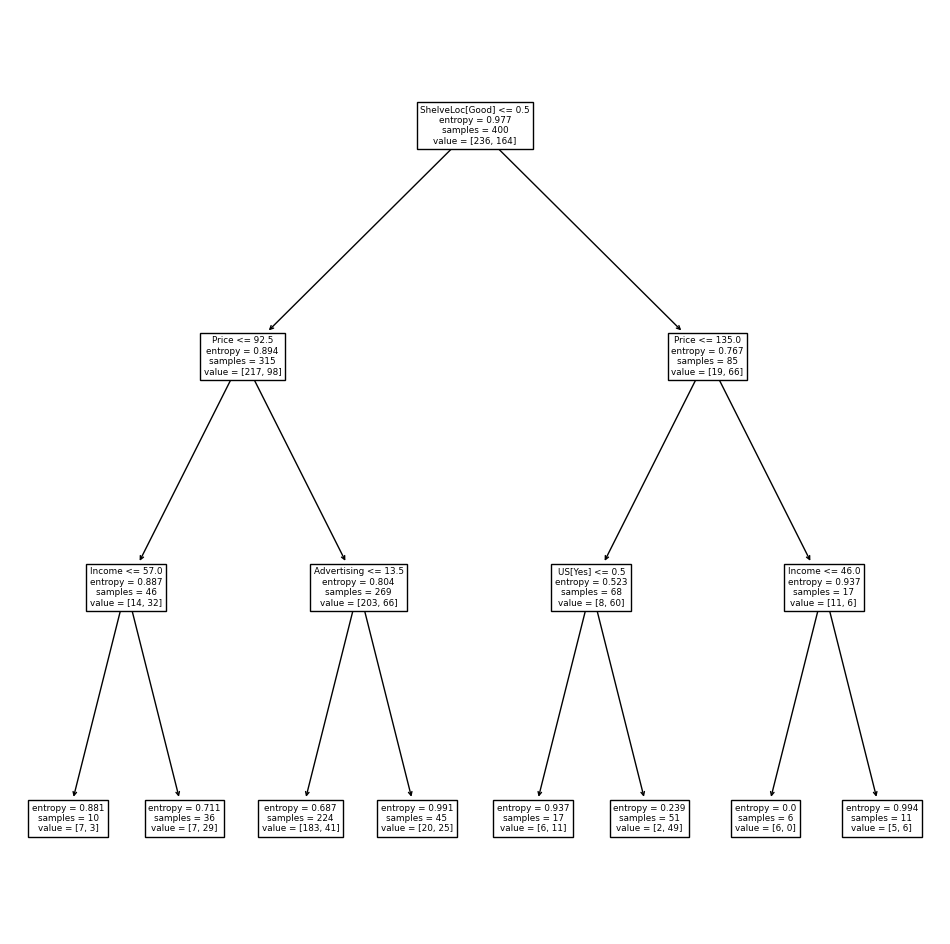

In [30]:
ax=subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [31]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [38]:
validation=skm.ShuffleSplit(n_splits=1,
                            test_size=200,
                            random_state=0)
results=skm.cross_validate(clf,
                           D,
                           High,
                           cv=validation)
results['test_score']

array([0.685])

In [40]:
(X_train,
 X_test,
 High_train,
 High_test)=skm.train_test_split(X,High,
                                 test_size=0.5,
                                 random_state=0)

In [42]:
clf=DTC(criterion='entropy',random_state=0)
clf.fit(X_train,High_train)
accuracy_score(High_test,clf.predict(X_test))

0.735

In [44]:
ccp_path=clf.cost_complexity_pruning_path(X_train,High_train)
kfold=skm.KFold(10,
                random_state=1,
                shuffle=True)

In [46]:
grid=skm.GridSearchCV(clf,
                      {'ccp_alpha':ccp_path.ccp_alphas},
                      refit=True,
                      cv=kfold,
                      scoring='accuracy')
grid.fit(X_train,High_train)
grid.best_score_

0.685

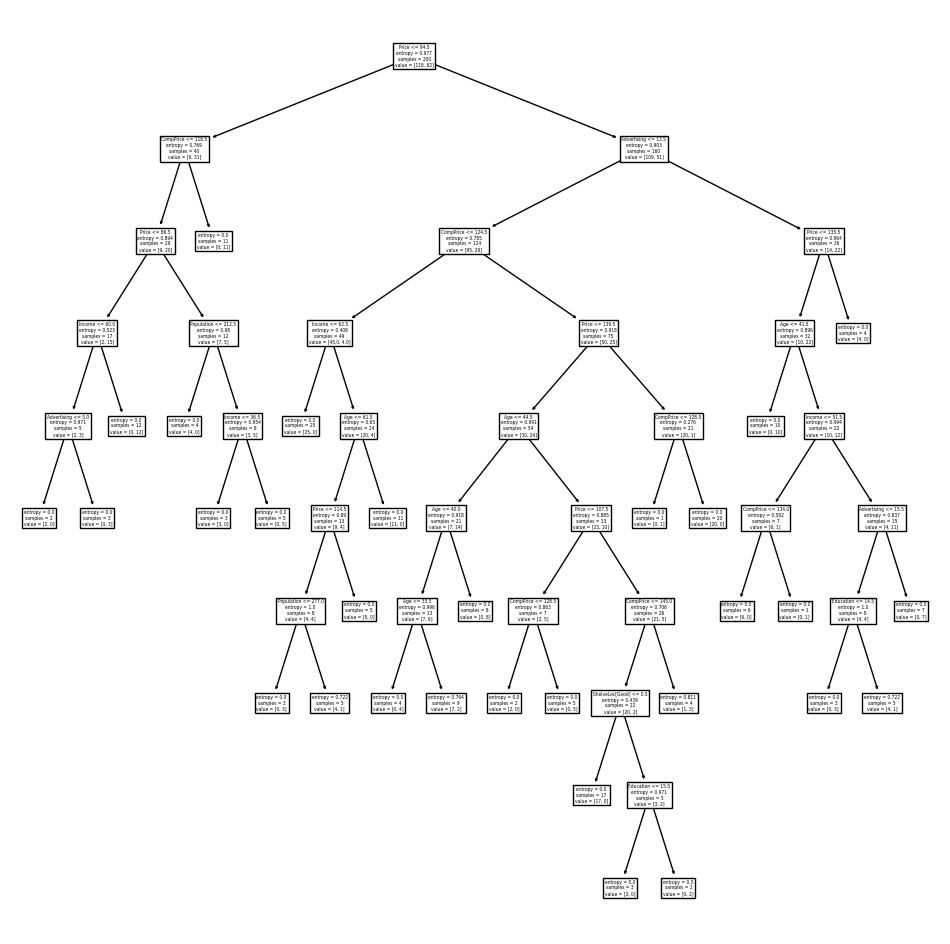

In [48]:
ax=subplots(figsize=(12,12))[1]
best=grid.best_estimator_
plot_tree(best ,
          feature_names=feature_names,
          ax=ax);

In [30]:
best.tree_.n_leaves

30

In [49]:
print(accuracy_score(High_test,
                     best.predict(X_test)))
confusion=confusion_table(best.predict(X_test),
                          High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


### **Fitting Regression Trees**

In [36]:
c=pd.read_csv('housing.csv')
California=c.drop(columns=['ocean_proximity'])
model=MS(California.columns.drop('median_house_value'),intercept=False)
D=model.fit_transform(California)
feature_names=list(D.columns)
X=np.asarray(D)

In [38]:
(X_train,
 X_test,
 y_train,
 y_test)=skm.train_test_split(X,
                              California['median_house_value'],
                              test_size=0.3,
                              random_state=0)

[Text(0.5, 0.875, 'median_income <= 5.029\nsquared_error = 13308271915.829\nsamples = 14448\nvalue = 206824.625'),
 Text(0.25, 0.625, 'median_income <= 3.067\nsquared_error = 8281492327.433\nsamples = 11381\nvalue = 173200.057'),
 Text(0.125, 0.375, 'latitude <= 34.455\nsquared_error = 5448662662.114\nsamples = 5469\nvalue = 134959.229'),
 Text(0.0625, 0.125, 'squared_error = 5352532975.108\nsamples = 2642\nvalue = 156402.505'),
 Text(0.1875, 0.125, 'squared_error = 4707175517.455\nsamples = 2827\nvalue = 114919.209'),
 Text(0.375, 0.375, 'housing_median_age <= 38.5\nsquared_error = 8297853090.516\nsamples = 5912\nvalue = 208575.409'),
 Text(0.3125, 0.125, 'squared_error = 6688680628.539\nsamples = 4684\nvalue = 195414.337'),
 Text(0.4375, 0.125, 'squared_error = 11254965828.784\nsamples = 1228\nvalue = 258776.112'),
 Text(0.75, 0.625, 'median_income <= 7.815\nsquared_error = 12197644067.037\nsamples = 3067\nvalue = 331598.412'),
 Text(0.625, 0.375, 'median_income <= 6.087\nsquared_err

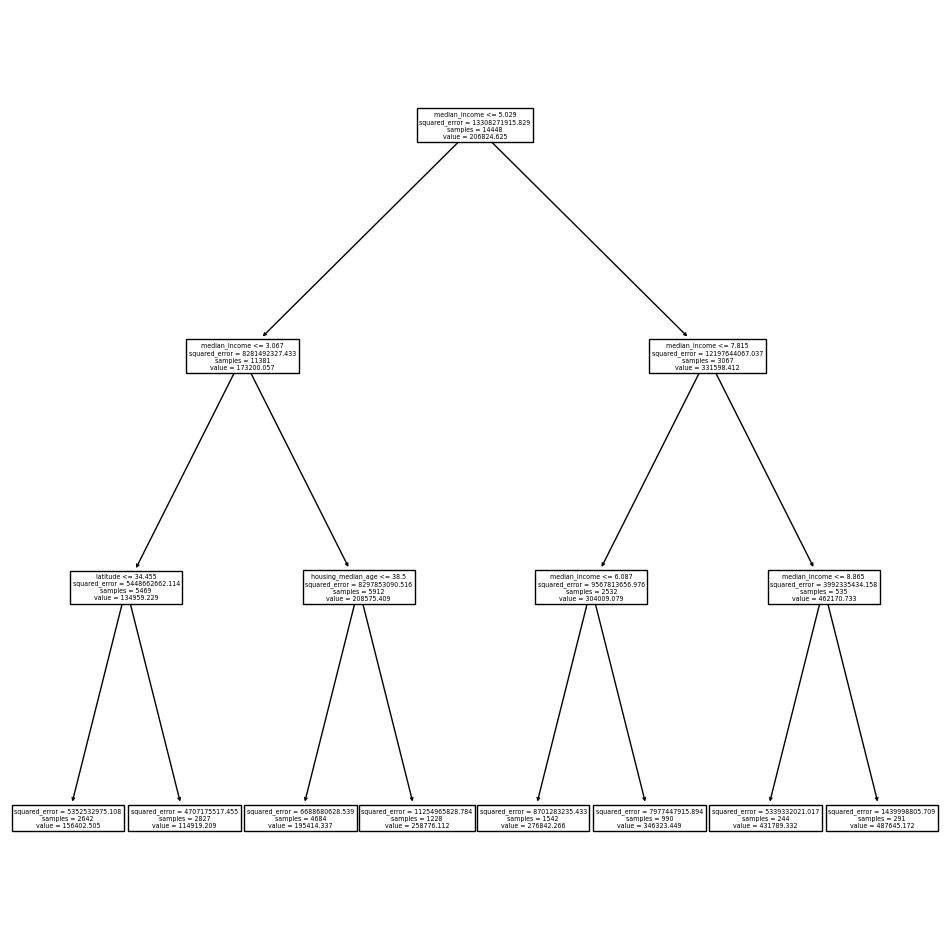

In [40]:
reg=DTR(max_depth=3)
reg.fit(X_train,y_train)
ax=subplots(figsize=(12,12))[1]
plot_tree(reg,feature_names=feature_names,
          ax=ax)

In [48]:
reg = DTR(random_state=42)
ccp_path=reg.cost_complexity_pruning_path(X_train,y_train)
kfold=skm.KFold(5,
                shuffle=True,
                random_state=10)
alphas_to_try=np.linspace(min(ccp_path.ccp_alphas), max(ccp_path.ccp_alphas), 20)
grid=skm.GridSearchCV(reg,
                      {'ccp_alpha':alphas_to_try},
                      refit=True,
                      cv=kfold,
                      scoring='neg_mean_squared_error')
G=grid.fit(X_train,y_train)

In [52]:
best=grid.best_estimator_
np.mean((y_test-best.predict(X_test))**2)

4805719741.128391

In [ ]:
ax=subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);